# Car Example with Discrete Control

This example uses the ModelicaXML backend and focuses on sampling and discrete control systems. For dynamics, it uses a simple bicycle model.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pymoca.parser import parse as parse_mo
from pymoca.backends.xml.parser import parse as parse_xml
from pymoca.backends.xml.generator import generate as gen_xml
import pymoca.backends.xml.analysis as analysis
import pymoca.backends.xml.sim_scipy as sim_scipy

In [2]:
car = parse_xml(gen_xml(parse_mo("""

class Car

    // bicycle kinematics
    Real x(start=0) "x position";
    Real y(start=0) "y position";
    Real v(start=0) "velocity";
    Real theta "heading";
    Real delta "steering angle";
    Real omega(start=0) "angular velocity";

    // model parameters
    parameter Real tau_delta = 0.1;
    parameter Real tau_v = 1;

    // sensor parameters
    parameter Real v_std = 0.1;
    parameter Real theta_std = 0.1;
    parameter Real omega_std = 0.01;
    parameter Real x_std = 0.5;
    parameter Real y_std = 0.5;

    // sensor variables
    discrete Real time_measure;
    discrete Real v_m;
    discrete Real theta_m;
    discrete Real omega_m;
    discrete Real x_m;
    discrete Real y_m;
    
    // controller parameters
    parameter Real steer_kP = 0.5;
    parameter Real steer_kD = 0.1;
    parameter Real throttle_kP = 1;
    parameter Real v_goal = 1;
    parameter Real theta_goal = 3.14;

    // discrete controller variables
    discrete Real thr_cmd(start=0) "normalized throttle command";
    discrete Real delta_cmd(start=0) "steering command";
    discrete Real time_control;

equation

    // sensor sampling
    when (time - time_measure > 0.1) then
        time_measure = time;
        v_m = v + noise_gaussian(0, v_std);
        theta_m = theta + noise_gaussian(0, theta_std);
        omega_m = omega + noise_gaussian(0, omega_std);
        x_m = x + noise_gaussian(0, x_std);
        y_m = y + noise_gaussian(0, y_std);
    end when;
    
    // discrete controller
    when (time - time_control > 0.1) then
        // control loop
        time_control = time;
        delta_cmd = steer_kP*(theta_goal - theta_m) - steer_kD*omega_m;
        thr_cmd = throttle_kP*(v_goal - v);
    end when;
    
    // kinematics
    der(x) = v*cos(delta)*cos(theta);
    der(y) = v*cos(delta)*sin(theta);
    der(theta) = omega;
    omega = v*sin(delta);

    // model motor as first order plant
    der(v) = (thr_cmd*2.0 - v)/tau_v;
    
    // model steering servo as first order plant
    der(delta) = (delta_cmd - delta)/tau_delta;

end Car;
"""), "Car"))
car


c       (  2):	[c_0, c_1]
dx      (  5):	[der(x), der(y), der(v), der(theta), der(delta)]
f_c     (  2):	@1=0.1, [(@1<(time-time_measure)), (@1<(time-time_control))]
f_i     (  5):	[x, y, v, theta, delta]
f_m     (  9):	@1=(c_0&&(!pre(c_0))), @2=(c_0&&(!pre(c_0))), @3=(c_0&&(!pre(c_0))), @4=(c_0&&(!pre(c_0))), @5=(c_0&&(!pre(c_0))), @6=(c_0&&(!pre(c_0))), @7=(c_1&&(!pre(c_1))), @8=(c_1&&(!pre(c_1))), @9=(c_1&&(!pre(c_1))), [((@1?time:0)+((!@1)?time_measure:0)), ((@2?(v+(v_std*ng_0)):0)+((!@2)?v_m:0)), ((@3?(theta+(theta_std*ng_1)):0)+((!@3)?theta_m:0)), ((@4?(omega+(omega_std*ng_2)):0)+((!@4)?omega_m:0)), ((@5?(x+(x_std*ng_3)):0)+((!@5)?x_m:0)), ((@6?(y+(y_std*ng_4)):0)+((!@6)?y_m:0)), ((@7?(throttle_kP*(v_goal-v)):0)+((!@7)?thr_cmd:0)), ((@8?((steer_kP*(theta_goal-theta_m))-(steer_kD*omega_m)):0)+((!@8)?delta_cmd:0)), ((@9?time:0)+((!@9)?time_control:0))]
f_x     (  6):	[(der(x)-((v*cos(delta))*cos(theta))), (der(y)-((v*cos(delta))*sin(theta))), (der(theta)-omega), (omega-(v*sin(delt

In [3]:
car_ode = car.to_ode()
car_ode


c       (  2):	[c_0, c_1]
dx      (  5):	[der(x), der(y), der(v), der(theta), der(delta)]
f_c     (  2):	@1=0.1, [(@1<(time-time_measure)), (@1<(time-time_control))]
f_i     (  5):	[x, y, v, theta, delta]
f_m     (  9):	@1=(c_0&&(!pre(c_0))), @2=(c_0&&(!pre(c_0))), @3=(c_0&&(!pre(c_0))), @4=(c_0&&(!pre(c_0))), @5=(c_0&&(!pre(c_0))), @6=(c_0&&(!pre(c_0))), @7=(c_1&&(!pre(c_1))), @8=(c_1&&(!pre(c_1))), @9=(c_1&&(!pre(c_1))), [((@1?time:0)+((!@1)?time_measure:0)), ((@2?(v+(v_std*ng_0)):0)+((!@2)?v_m:0)), ((@3?(theta+(theta_std*ng_1)):0)+((!@3)?theta_m:0)), ((@4?(omega+(omega_std*ng_2)):0)+((!@4)?omega_m:0)), ((@5?(x+(x_std*ng_3)):0)+((!@5)?x_m:0)), ((@6?(y+(y_std*ng_4)):0)+((!@6)?y_m:0)), ((@7?(throttle_kP*(v_goal-v)):0)+((!@7)?thr_cmd:0)), ((@8?((steer_kP*(theta_goal-theta_m))-(steer_kD*omega_m)):0)+((!@8)?delta_cmd:0)), ((@9?time:0)+((!@9)?time_control:0))]
f_x_rhs (  5):	[((v*cos(delta))*cos(theta)), ((v*cos(delta))*sin(theta)), (((2*thr_cmd)-v)/tau_v), omega, ((delta_cmd-delta)/tau_d

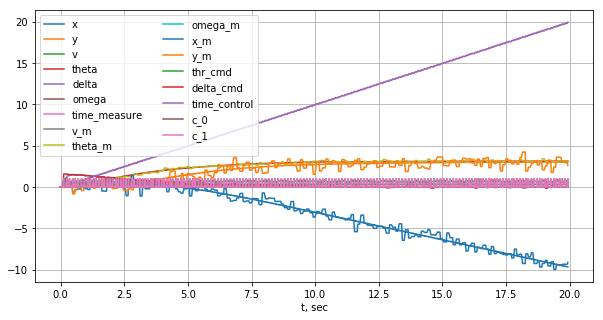

In [4]:
plt.figure(figsize=(10, 5))
data = sim_scipy.sim(car_ode, {'tf': 20, 'dt': 0.05})
analysis.plot(data)

Text(0.5,1,'top down view of vehicle trajectory')

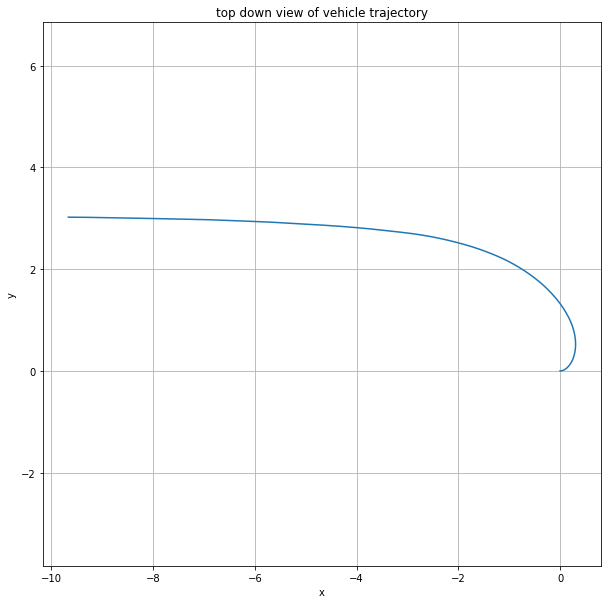

In [5]:
plt.figure(figsize=(10, 10))
plt.plot(data['x'][:,0], data['x'][:,1])
plt.grid()
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.title('top down view of vehicle trajectory')

Text(0.5,1,'steering angle')

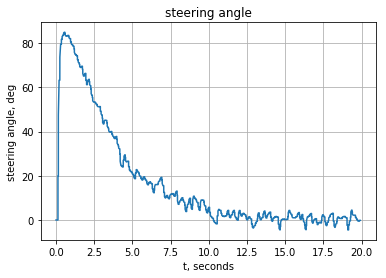

In [6]:
plt.plot(data['t'], np.rad2deg(data['x'][:, 4]))
plt.grid()
plt.xlabel('t, seconds')
plt.ylabel('steering angle, deg')
plt.title('steering angle')

Text(0.5,1,'heading')

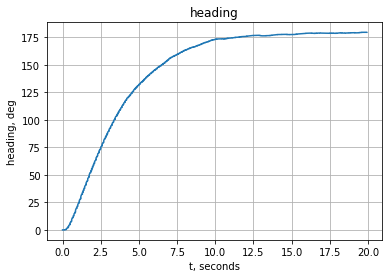

In [7]:
plt.plot(data['t'], np.rad2deg(data['x'][:, 3]))
plt.grid()
plt.xlabel('t, seconds')
plt.ylabel('heading, deg')
plt.title('heading')

In [8]:
import casadi as ca
ca.substitute(car_ode.f_m, car_ode.ng, 0)

SX(@1=(c_0&&(!pre(c_0))), @2=(c_0&&(!pre(c_0))), @3=(c_0&&(!pre(c_0))), @4=(c_0&&(!pre(c_0))), @5=(c_0&&(!pre(c_0))), @6=(c_0&&(!pre(c_0))), @7=(c_1&&(!pre(c_1))), @8=(c_1&&(!pre(c_1))), @9=(c_1&&(!pre(c_1))), [((@1?time:0)+((!@1)?time_measure:0)), ((@2?v:0)+((!@2)?v_m:0)), ((@3?theta:0)+((!@3)?theta_m:0)), ((@4?omega:0)+((!@4)?omega_m:0)), ((@5?x:0)+((!@5)?x_m:0)), ((@6?y:0)+((!@6)?y_m:0)), ((@7?(throttle_kP*(v_goal-v)):0)+((!@7)?thr_cmd:0)), ((@8?((steer_kP*(theta_goal-theta_m))-(steer_kD*omega_m)):0)+((!@8)?delta_cmd:0)), ((@9?time:0)+((!@9)?time_control:0))])